© 2025 Zitao Yang, Rebecca J. Rousseau, Sara D. Mahdavi, Hernan G. Garcia, and Rob Phillips, *The Dynamics of Inducible Genetic Circuits*. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).
___

# Bistability in mutual repression as a function of cooperativities and expression rate

This notebook generates the plots shown in Figure 18 of the paper, and specifically discusses how the threshold separating bistable from monostable systems in cooperativity $(\omega_1,\omega_2)$ phase space changes with increasing rate $r$.

In [2]:
from numba import njit
import numpy as np
import math
from numba import prange
import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm


from skimage.measure import find_contours
from scipy.stats import binned_statistic
from scipy.ndimage import gaussian_filter1d

## Parameters and helper functions

In [4]:
delE=4.5
Ka=1.4*10**(-4)
Ki=5.3*10**(-7)
K_c=Ka/Ki

@njit
def pAct(c, K_c=K_c, delE=delE):
    """ probability of repressor being active

    Parameters:
        - c: inducer concentration
        - K_c: ratio of dissociation constants for active vs. inactive states
        - delE: energy difference between inactive and active state
    """

    p = (1 + c/Ka)**2 / ((1 + c/Ka)**2 + np.exp(-delE)*(1 + c/Ki)**2)
    #p= (1 + c)**2 / ((1 + c)**2 + np.exp(-delE)*(1 + c*K_c)**2)
    return p

c_values = np.logspace(-7, -4, 100)
pmin=1/(1+K_c**2*np.exp(-delE))
pmax=1/(1+np.exp(-delE))
p_values = np.linspace(pmin, pmax, 1000)

r_list = np.array([1, 2, 5, 6, 7, 10, 20])
K_fixed = 1 
omegaA = 7.5
omegaB = 7.5
n_sampling_c = 100

color_1 = '#FFF5F0'  
color_2 = '#99000D'  

# Binary discrete colormap
binary_cmap = ListedColormap([color_1, color_2])
bounds = [0, 0.5, 1] 
norm = BoundaryNorm(bounds, binary_cmap.N)

## Helper functions to find steady states

In [6]:
# We find the roots with a bisection method, to be able to parallelize with numba
@njit
def find_intersections(x, y1, y2):
    """
    Find intersections (x,y) between two curves y1(x) and y2(x).

    Parameters:
        - x: 1D array of x values (must be sorted)
        - y1: 1D array of y values for the first curve
        - y2: 1D array of y values for the second curve
    """
    intersections = []
    for i in prange(len(x) - 1):
        diff1 = y1[i] - y2[i]
        diff2 = y1[i + 1] - y2[i + 1]
        if diff1 * diff2 < 0:  # sign change : intersection
            # linear interpolation
            x_intersect = x[i] - diff1 * (x[i + 1] - x[i]) / (diff2 - diff1)
            # linear interpolation
            y_intersect = y1[i] + (y1[i + 1] - y1[i]) * (x_intersect - x[i]) / (x[i + 1] - x[i])
            intersections.append((x_intersect, y_intersect))
    return intersections


@njit
def steady_state(r, K, omegaA, omegaB, pactA, pactB):
  """
  Compute steady states for a given set of parameters from the intersections
  of the nullclines for the mutual repression model.

  Parameters:
      - r: rate of expression
      - K: ratio of dissociation constants for repressor 1 vs. repressor 2
      - omegaA: cooperativity for repressor 1
      - omegaB: cooperativity for repressor 2
      - pactA: probability of activity for repressor 1
      - pactB: probability of activity for repressor 2
  """
  Btilde=np.linspace(0,r,n_sampling_c)
  fA=r/(1+2*pactB*Btilde+omegaB*(pactB*Btilde)**2)
  fm1B=(np.sqrt(1-omegaA*(1-r/Btilde))-1)/omegaA/(pactA/K)
  return find_intersections(Btilde, fA, fm1B)


## Helper functions to determine bistability in $(\omega_1,\omega_2)$ phase space

In [8]:
@njit
def bistable_or_not(r, K, omegaA, omegaB, p_val=p_values):
  """
  Spanning inducer phase space for repressors 1 and 2, determine for a given set of parameters whether the system
  is bistable or monostable at each possible pair of sampled inducer concentrations

  Parameters:
      - r: rate of expression
      - K: ratio of dissociation constants for repressor 1 vs. repressor 2
      - omegaA: cooperativity for repressor 1
      - omegaB: cooperativity for repressor 2
      - p_val: probability of activity for repressors 1 and 2
  """
  npval=len(p_val)
  bs_bool = np.zeros((npval, npval), dtype=np.int64)
  for iA in prange(npval):
    pA=p_val[iA]
    for iB in prange(npval):
      pB=p_val[iB]
      Ass = steady_state(r, K, omegaA, omegaB, pA, pB)
      if len(Ass) == 1:
        bs_bool[iA, iB] = 0
      else:
        bs_bool[iA, iB] = 1
  return bs_bool


@njit
def bistab_exploration_omegaA_omegaB(r, K, omegaA_values, omegaB_values, p_val=p_values):
  """
  Spanning cooperativity (w1, w2) phase space, determine for a given set of parameters whether
  it is possible for the system to bistable at some inducer concentrations (c1, c2)

  Parameters:
      - r: rate of expression
      - K: ratio of dissociation constants for repressor 1 vs. repressor 2
      - omegaA_values: sampled values of cooperativity for repressor 1
      - omegaB_values: sampled values of cooperativity for repressor 2
      - p_val: probability of activity for repressors 1 and 2
  """
  nsampling=len(omegaA_values)
  bistable_omegaA_omegaB = np.zeros((nsampling,nsampling))
  for iA in prange(nsampling):
    omegaAval=omegaA_values[iA]
    for iB in prange(nsampling):
      omegaBval=omegaB_values[iB]
      heatmap=bistable_or_not(r, K, omegaAval, omegaBval, p_val)
      bool_bistable = np.any(heatmap == 1)
      bistable_omegaA_omegaB[iA,iB] = int(bool_bistable)
  return bistable_omegaA_omegaB


@njit
def omega_min_bistab_for_K(r, K_values, omega_values, p_val=p_values):
  """
  Assuming both repressors have the same cooperativity, compute the minimum cooperativity
  observed to allow bistability over the sampled set of K

  Parameters:
      - r: rate of expression
      - K_values: ratio of dissociation constants for repressor 1 vs. repressor 2
      - omega_values: cooperativity for repressors 1 and 2
      - p_val: probability of activity for repressors 1 and 2
  """
  n_K = len(K_values)
  n_omega = len(omega_values)
  omega_bistab_for_K  = np.zeros(n_K)
  omega_list = np.full((n_K,n_omega),np.nan)
  for ik in prange(n_K):
    Kval=K_values[ik]
    for i_omega in prange(n_omega):
      omegaval=omega_values[i_omega]
      heatmap=bistable_or_not(r, Kval, omegaval, omegaval, p_val)
      bool_bistable = np.any(heatmap == 1)
      if bool_bistable:
        omega_list[ik][i_omega] = omegaval
    omega_bistab = np.nanmin(omega_list[ik])
    omega_bistab_for_K[ik] = omega_bistab
  return omega_bistab_for_K

@njit
def omegaA_min_bistab_for_K_and_omegaB(r, K_values, omega_values, p_val=p_values):
  """
  Compute the minimum cooperativity for repressor 1 observed to allow bistability 
  over the sampled set of K

  Parameters:
      - r: rate of expression
      - K_values: ratio of dissociation constants for repressor 1 vs. repressor 2
      - omega_values: cooperativity
      - p_val: probability of activity for repressors 1 and 2
  """
  n_K = len(K_values)
  n_omega = len(omega_values)
  omega_bistab_for_K_and_omegaB  = np.zeros((n_K,n_omega))
  for ik in prange(n_K):
    Kval=K_values[ik]
    for i_omega in prange(n_omega):
      omegaBval=omega_values[i_omega]
      omega_list = np.full(n_omega,np.nan)
      for j_omega in prange(n_omega):
        omegaAval=omega_values[j_omega]
        heatmap=bistable_or_not(r, Kval, omegaAval, omegaBval, p_val)
        bool_bistable = np.any(heatmap == 1)
        if bool_bistable:
          omega_list[j_omega] = omegaAval
      omegaA_min_bistab = np.nanmin(omega_list)
      omega_bistab_for_K_and_omegaB[ik][i_omega] = omegaA_min_bistab
  return omega_bistab_for_K_and_omegaB



@njit
def K_max_min_bistab_for_K_and_omegaB(r, K_values, omega_values, p_val=p_values):
  """
  Compute the maximum and minimum values for K for which the system is observed 
  to allow bistability

  Parameters:
      - r: rate of expression
      - K_values: ratio of dissociation constants for repressor 1 vs. repressor 2
      - omega_values: cooperativity
      - p_val: probability of activity for repressors 1 and 2
  """
  n_K = len(K_values)
  n_omega = len(omega_values)
  K_min_for_omegaA_and_omegaB = np.zeros((n_omega,n_omega))
  K_max_for_omegaA_and_omegaB = np.zeros((n_omega,n_omega))
  for i_omegaA in prange(n_omega):
    omegaAval=omega_values[i_omegaA]
    for i_omegaB in prange(n_omega):
      omegaBval=omega_values[i_omegaB]
      K_list = np.full(n_K,np.nan)
      for ik in prange(n_K):
        Kval = K_values[ik]
        heatmap=bistable_or_not(r, Kval, omegaAval, omegaBval, p_val)
        bool_bistable = np.any(heatmap == 1)
        if bool_bistable:
          K_list[ik] = Kval
      K_max = np.nanmax(K_list)
      K_min = np.nanmin(K_list)
      K_min_for_omegaA_and_omegaB[i_omegaA][i_omegaB] = K_min
      K_max_for_omegaA_and_omegaB[i_omegaA][i_omegaB] = K_max
  return K_min_for_omegaA_and_omegaB, K_max_for_omegaA_and_omegaB

# Compute all the (w1,w2) phase space for different r
@njit(parallel=True)
def bistability_map_for_different_r(r_vals, omegaA, omegaB, p_val, K):
    """
    Spanning cooperativity (w1, w2) phase space, determine for a given set of parameters whether
    it is possible for the system to bistable at some inducer concentrations (c1, c2), and evaluate
    this for a range of possible expression rates r

    Parameters:
        - r_vals: sampled rates of expression
        - omegaA: cooperativity for repressor 1
        - omegaB: ccooperativity for repressor 2
        - p_val: probability of activity for repressors 1 and 2
        - K: ratio of dissociation constants for repressor 1 vs. repressor 2
    """
    n = len(r_vals)
    L_stack = np.empty((n, len(omegaB), len(omegaA)))
    for i in prange(n):
        L_stack[i] = bistab_exploration_omegaA_omegaB(r_vals[i], K, omegaA_values, omegaB_values, p_val=p_values)
    return L_stack


## functions to save files 

In [10]:
## To save the bistability phase space in (w1,w2) space
def storing_array_csv(L, omegaA_values, omegaB_values, p_values, r, K):
    filename = folder + 'bistable_map_logomegamax='+str(int(np.log10(min(omegaA_values))))+'_logomegamax='+str(int(np.log10(max(omegaA_values))))+'_nsampling='+str(len(omegaA_values))+'_np='+str(len(p_values))+'_r='+str(r)+'_K='+str(K)+'.csv'
    OmegaA, OmegaB = np.meshgrid(omegaA_values, omegaB_values)

    data = {
        "omegaA": OmegaA.ravel(),
        "omegaB": OmegaB.ravel(),
        "L_value": L.ravel()
    }

    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

    print(f"Saved {len(df)} rows to '{filename}'")

# Function to upload a .cvs file into an array
def load_array_from_csv(filename):
    df = pd.read_csv(filename)

    omegaA_values = np.sort(df['omegaA'].unique())
    omegaB_values = np.sort(df['omegaB'].unique())

    omegaA_idx = {v: i for i, v in enumerate(omegaA_values)}
    omegaB_idx = {v: i for i, v in enumerate(omegaB_values)}

    L = np.empty((len(omegaB_values), len(omegaA_values)))

    for _, row in df.iterrows():
        i = omegaB_idx[row['omegaB']]
        j = omegaA_idx[row['omegaA']]
        L[i, j] = row['L_value']

    return L, omegaA_values, omegaB_values

In [11]:
# Generating the phase space - for a good resolution this is long. to have the phase spaces for all r with the sampling
# that is displayed in the paper, this would take overnight. The parameters used for the main text figure are commented hereafter

# nsampling = 300
# omegaA_values = np.logspace(-2, 2, nsampling)
# omegaB_values = np.logspace(-2, 2, nsampling)
# p_values = np.linspace(pmin, pmax, 1000)

# We use other parameters to show that the code runs and the files with the arrays used in the main text are enclosed:                             
nsampling = 100
omegaA_values = np.logspace(-2, 2, nsampling)
omegaB_values = np.logspace(-2, 2, nsampling)
p_values = np.linspace(pmin, pmax, 100)

# Run the parallel computation
phase_space_for_different_r = bistability_map_for_different_r(r_list, omegaA_values, omegaB_values, p_values, K_fixed)

In [12]:
#Storing the files - if needed
# for i in range(len(r_list)):
#     storing_array_csv(phase_space_for_different_r[i], omegaA_values, omegaB_values, p_values,r_list[i],1)

In [13]:
# Compile higher resolution data from csv files in repository folder

phase_space_for_different_r_high_resolution =[]
omega_list =[]
notebook_dir = os.getcwd()
for i in range(len(r_list)):
    filename_r = 'mutual_repressionbistable_map_logomegamax=-2_logomegamax=2_nsampling=300_np=1000_r='+str(r_list[i])+'_K=1.csv' 
    file_path = os.path.join(notebook_dir, filename_r)
    L_of_r, omegaa,omegab = load_array_from_csv(file_path)
    phase_space_for_different_r_high_resolution+= [L_of_r]
    omega_list +=[omegaa]

In [14]:
# To generate those arrays run:
# nsampling = 300
# omegaA_values = np.logspace(-2, 2, nsampling)
# omegaB_values = np.logspace(-2, 2, nsampling)
# p_values = np.linspace(pmin, pmax, 1000)

# phase_space_for_different_r = bistability_map_for_different_r(r_list, omegaA_values, omegaB_values, p_values, K_fixed)

## (A): $(\omega_1, \omega_2)$ phase space at an example rate, $\bar{r} = 1$

This panel delineates this phase space into two regions: pale red if monostable for any $(c_1,c_2)$, or red if bistalbe for some $(c_1, c_2)$.

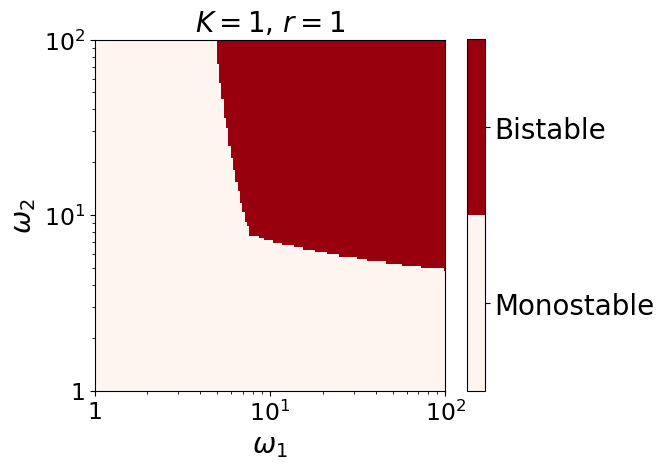

In [16]:
i = 0
K=1
plt.figure()
Z = np.transpose(phase_space_for_different_r_high_resolution[i])

plt.pcolormesh(omega_list[i], omega_list[i], Z,
               cmap=binary_cmap, shading='auto', rasterized=True)

plt.xscale('log')
plt.yscale('log')

plt.xticks([ 1, 10, 100],
           [r"$1$", r"$10^1$", r"$10^2$"], size=17)
plt.yticks([ 1, 10, 100],
           [ r"$1$", r"$10^1$", r"$10^2$"], size=17)

plt.xlabel(r'$\omega_1$', size=20)
plt.ylabel(r'$\omega_2$', size=20)
plt.title(r'$K=$' + str(K) + r', $r=$' + str(r_list[0]), size=20)


cbar = plt.colorbar(ticks=[0.25, 0.75])
cbar.ax.set_yticklabels(['Monostable', 'Bistable'])
cbar.ax.tick_params(labelsize=20)

plt.xlim(1, 100)
plt.ylim(1, 100)
plt.gca().set_aspect('equal')

plt.tight_layout()

## (B): Evolution of the bistable region as $\bar{r}$ increases

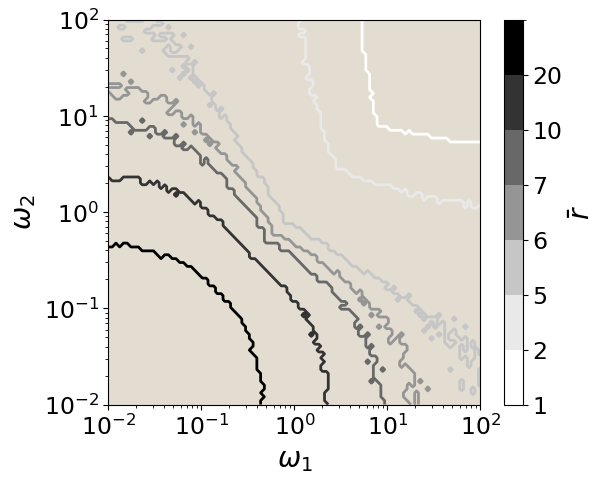

In [18]:
# Custom colormap normalized to the range of r values
norm = colors.Normalize(vmin=min(r_list), vmax=max(r_list))
cmap = cm.Grays

n_r = len(r_list)
colors_list = [cmap(i / (n_r - 1)) for i in range(n_r)]

fig, ax = plt.subplots(figsize=(6, 5))

ax.set_facecolor('#E3DCD1')        # background inside the axes area

# Plot each contour
for i, r in enumerate(r_list):
    Z = np.transpose(phase_space_for_different_r[i])
    cs = ax.contour(omegaA_values, omegaB_values, Z, levels=[0.5],colors=[colors_list[i]], linewidths=2, linestyles='solid')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([0.01,0.1,1, 10, 100])
ax.set_xticklabels( [r"$10^{-2}$", r"$10^{-1}$",r"$10^0$", r"$10^1$", r"$10^2$"], size=17)
ax.set_yticks([0.01,0.1,1, 10, 100])
ax.set_yticklabels( [r"$10^{-2}$", r"$10^{-1}$",r"$10^0$", r"$10^1$", r"$10^2$"], size=17)
ax.set_xlabel(r'$\omega_1$', size=20)
ax.set_ylabel(r'$\omega_2$', size=20)

#Color bar formating
discrete_cmap = ListedColormap(colors_list)
norm = BoundaryNorm(np.arange(len(r_list) + 1), discrete_cmap.N)
sm = cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(len(r_list)))
cbar.ax.set_yticklabels([str(r) for r in r_list])

cbar.set_label(r'$\bar{r}$', size=20)
cbar.ax.tick_params(labelsize=17)


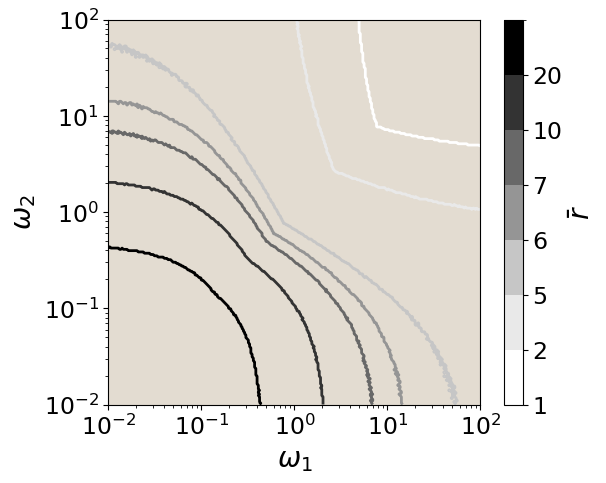

In [19]:
# Plot higher-resolution image from higher-resolution data stored in this repository folder

# Custom colormap normalized to the range of r values
norm = colors.Normalize(vmin=min(r_list), vmax=max(r_list))
cmap = cm.Grays

n_r = len(r_list)
colors_list = [cmap(i / (n_r - 1)) for i in range(n_r)]

fig, ax = plt.subplots(figsize=(6, 5))

ax.set_facecolor('#E3DCD1')        # background inside the axes area

# Plot each contour
for i, r in enumerate(r_list):
    Z = np.transpose(phase_space_for_different_r_high_resolution[i])
    cs = ax.contour(omega_list[i], omega_list[i], Z, levels=[0.5],colors=[colors_list[i]], linewidths=2, linestyles='solid')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([0.01,0.1,1, 10, 100])
ax.set_xticklabels( [r"$10^{-2}$", r"$10^{-1}$",r"$10^0$", r"$10^1$", r"$10^2$"], size=17)
ax.set_yticks([0.01,0.1,1, 10, 100])
ax.set_yticklabels( [r"$10^{-2}$", r"$10^{-1}$",r"$10^0$", r"$10^1$", r"$10^2$"], size=17)
ax.set_xlabel(r'$\omega_1$', size=20)
ax.set_ylabel(r'$\omega_2$', size=20)

#color bar formating
discrete_cmap = ListedColormap(colors_list)
norm = BoundaryNorm(np.arange(len(r_list) + 1), discrete_cmap.N)
sm = cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(len(r_list)))
cbar.ax.set_yticklabels([str(r) for r in r_list])

cbar.set_label(r'$\bar{r}$', size=20)
cbar.ax.tick_params(labelsize=17)
